### **Imports and utils**

Importing libraies

In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, Concatenate, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.metrics import Accuracy
#from sklearn.model_selection import train_test_split

Utils functions

In [50]:
def read_header_and_data(file_path, idx):
    with fits.open(file_path) as hdu:
        header = hdu[idx].header
        data = hdu[idx].data

        return header, data

def show_image(image_data, cmap='gist_gray'):
    plt.figure()
    plt.imshow(image_data, cmap=cmap)
    plt.colorbar()

def mean_subtract(img_data):
    img_mean = np.mean(img_data)
    img_data -= img_mean

    return img_data

def normalize(array):
    arr_max = np.max(array)
    arr_min = np.min(array)

    arr_normalized = (array - arr_min) / (arr_max - arr_min)

    return arr_normalized

def normalize_list(list_arrays):
    list_arrays_normalized = []
    list_arrays_normalized += [normalize(array) for array in list_arrays]
    list_arrays_normalized = np.array(list_arrays_normalized)

    return list_arrays_normalized

### **Denoising**

Opening denoising data

In [51]:
image_file_path = 'output_denoising_snr100.fits'
img_head, img_data = read_header_and_data(image_file_path, 0)

ResUNet

In [54]:
# from paper Qian, H. et al 2022

def resnet_block(x, x_shortcut, num_filters, kernel_size=3):
    # Main block
    rb = Conv2D(num_filters, kernel_size, padding='same')(x)
    rb = BatchNormalization()(rb)
    rb = Activation('relu')(rb)
    rb = Conv2D(num_filters, kernel_size, padding='same')(rb)

    # Add
    x_shortcut = Conv2D(num_filters, kernel_size=1, padding='same')(x_shortcut)
    #x_shortcut = BatchNormalization()(x_shortcut)
    rb = Add()([x_shortcut, rb])

    return rb

def upsample_concatenate(x, skip):
    x = UpSampling2D((2, 2))(x)

    return Concatenate()([x, skip])

def resUnet(input_shape=(48, 48, 1), num_filters=64, num_resnetblocks=4, kernel_size=3): # change filters dynamically and check blocks
    inputs = Input(input_shape)

    # Encoder
    x = inputs
    skip_connections = []
    for i in range(num_resnetblocks):
        if not i == 0: x = BatchNormalization()(x)
        x = resnet_block(x, x, num_filters, kernel_size)
        if not i == num_resnetblocks-1:
            skip_connections += [x] # copy maybe
            x = Conv2D(num_filters, kernel_size, strides=2, padding='same')(x)

    # Transition
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters * 2, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters * 2, kernel_size, padding='same')(x)

    # Decoder
    for skip in reversed(skip_connections):
        x = upsample_concatenate(x, skip)
        x_shortcut = x
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = resnet_block(x, x_shortcut, num_filters, kernel_size)

    x = BatchNormalization()(x)
    x = Conv2D(num_filters, kernel_size, padding='same')(x)

    outputs = Conv2D(1, 1, activation='sigmoid')(x)
    network = Model(inputs, outputs)

    return network

Training ResUnet

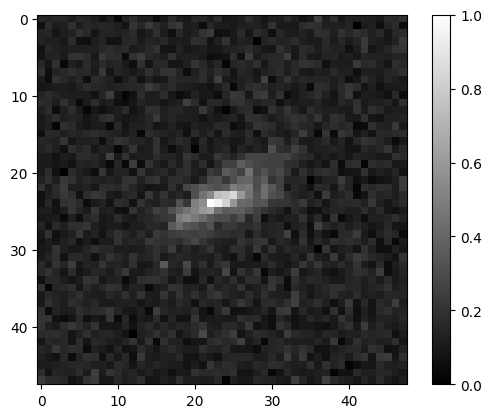

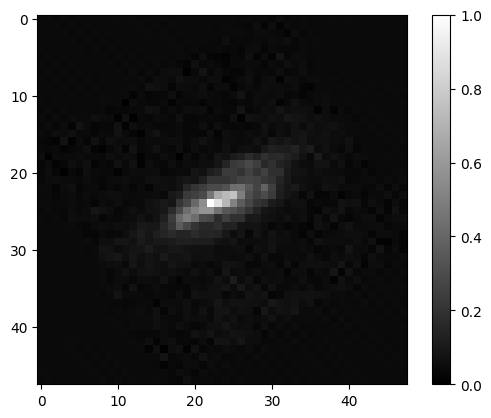

In [55]:
#img_data = np.random.permutation(img_data)
img_data = normalize_list(img_data)
img_size = img_data[0].shape[0]
num_total = len(img_data)
train_split = 0.7
train_idx = int(num_total * train_split)

img_data = np.array([np.reshape(img, (img_size, img_size, 1)) for img in img_data])
img_shape = img_data[0].shape

# Spliting training and testing
train = img_data[0:train_idx]

train_x = img_data[[i for i in range(0, len(train), 2)]]
train_y = img_data[[i for i in range(1, len(train), 2)]]

test = img_data[train_idx:num_total]
test_x = img_data[[i for i in range(0, len(test), 2)]]
test_y = img_data[[i for i in range(1, len(test), 2)]]

idx = 0
show_image(test_x[idx])
show_image(test_y[idx])

In [56]:
resunet_model = resUnet(input_shape=img_shape, num_filters=64, num_resnetblocks=4, kernel_size=3)
resunet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv2d_56 (Conv2D)          (None, 48, 48, 64)           640       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_32 (Ba  (None, 48, 48, 64)           256       ['conv2d_56[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_24 (Activation)  (None, 48, 48, 64)           0         ['batch_normalization_32

In [57]:
resunet_model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mse'])

batch_size = 128
epochs = 25
history = resunet_model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(test_x, test_y))

Epoch 1/25
55/55 [==============================] - 31s 290ms/step - loss: 0.0474 - mse: 0.0474 - val_loss: 0.8907 - val_mse: 0.8907
Epoch 2/25
55/55 [==============================] - 10s 182ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0292 - val_mse: 0.0292
Epoch 3/25
55/55 [==============================] - 10s 182ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 4/25
55/55 [==============================] - 10s 183ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 5/25
55/55 [==============================] - 10s 183ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 6/25
55/55 [==============================] - 10s 184ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 7/25
55/55 [==============================] - 10s 186ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 8/25
55/55 [==============================] - 10s 187ms/step - 

94/94 [==============================] - 2s 20ms/step


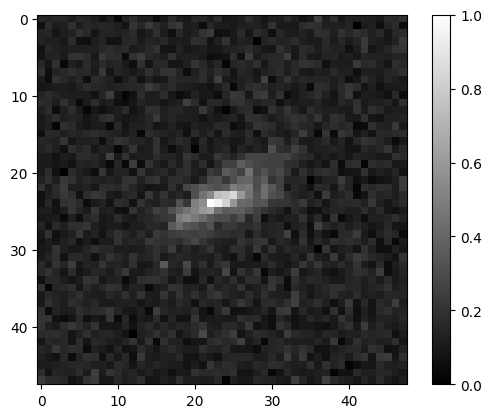

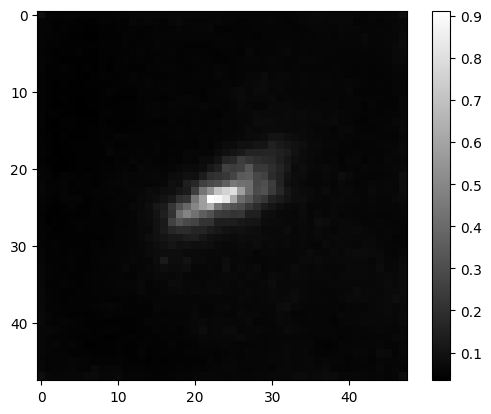

In [61]:
predictions = resunet_model.predict(test_x)
idx = 0
show_image(test_x[idx])
show_image(predictions[idx])

**Deconvolution**

Unrolled ADMM Network